In [199]:
# Set filenames & co to quickly change file
file = 'calligraphy'
folder = 'comparison'
filename_scan = f'{folder}/{file}.png'
filename_svg = f'{folder}/{file}_vectorized.svg'
# Save final plot or not
save_final_plot = True
filename_result_figure = f'{file}_final_plot'

In [214]:
from skimage.io import imsave
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

plt.rcParams['savefig.pad_inches'] = 0
plt.rcParams["savefig.bbox"] = 'Tight'

zoom_factor = 8


def zoom_img(image):
    if len(np.shape(image)) == 2:
        return zoom(image, zoom_factor, order=0)
    else:
        return zoom(image, (zoom_factor, zoom_factor, 1), order=0)


def save_img(image, name, zoom=True):
    imsave(f'{folder}/{name}.png', zoom_img(image) if zoom else image)


def save_plt_svg(name):
    plt.savefig(f'{folder}/{name}.svg')


def plot_detail_on_image_and_save(filename, fig, detail_center=[1445, 345], half_y=40, half_x=30, zoom=2.5,
                                  top_start_x=1010, top_start_y=10, change_corners=False, multiplier=1):
    detail_center[0] = detail_center[0] * multiplier
    detail_center[1] = detail_center[1] * multiplier
    half_y = int(half_y * multiplier)
    half_x = int(half_x * multiplier)
    top_start_x = int(top_start_x * multiplier)
    top_start_y = int(top_start_y * multiplier)

    canvas = FigureCanvas(fig)
    ax = fig.gca()
    canvas.draw()  # draw the canvas, cache the renderer
    width, height = np.int64(fig.get_size_inches() * fig.get_dpi())
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)
    x = int(detail_center[0])
    y = int(detail_center[1])
    detail = image[y - half_x:y + half_x + 1, x - half_y:x + half_y + 1]
    magnified = scipy.ndimage.zoom(detail, [zoom, zoom, 1], order=0)
    detail_width = len(magnified)
    detail_height = len(magnified[0])

    if change_corners:
        frame = np.array([
            [top_start_x - 2, top_start_y + detail_width + 1],
            [top_start_x - 2, top_start_y - 2],
            [top_start_x + detail_height + 1, top_start_y - 2],
            [top_start_x + detail_height + 1, top_start_y + detail_width + 1],
            [top_start_x - 2, top_start_y + detail_width + 1],
            [x + half_y, y - half_x],
            [x + half_y, y + half_x],
            [x - half_y, y + half_x],
            [x - half_y, y - half_x],
            [x + half_y, y - half_x]
        ])
    else:
        frame = np.array([
            [top_start_x + detail_height + 1, top_start_y + detail_width + 1],
            [top_start_x - 2, top_start_y + detail_width + 1],
            [top_start_x - 2, top_start_y - 2],
            [top_start_x + detail_height + 1, top_start_y - 2],
            [top_start_x + detail_height + 1, top_start_y + detail_width + 1],
            [x - half_y, y - half_x],
            [x + half_y, y - half_x],
            [x + half_y, y + half_x],
            [x - half_y, y + half_x],
            [x - half_y, y - half_x]
        ])

    ax.plot(frame[:, 0], frame[:, 1], color='r', linewidth=4)
    canvas.draw()
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)
    out_image = np.copy(image)
    out_image[top_start_y:top_start_y + detail_width, top_start_x:top_start_x + detail_height] = magnified

    save_img(out_image, filename, multiplier == 1)

## Import image

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


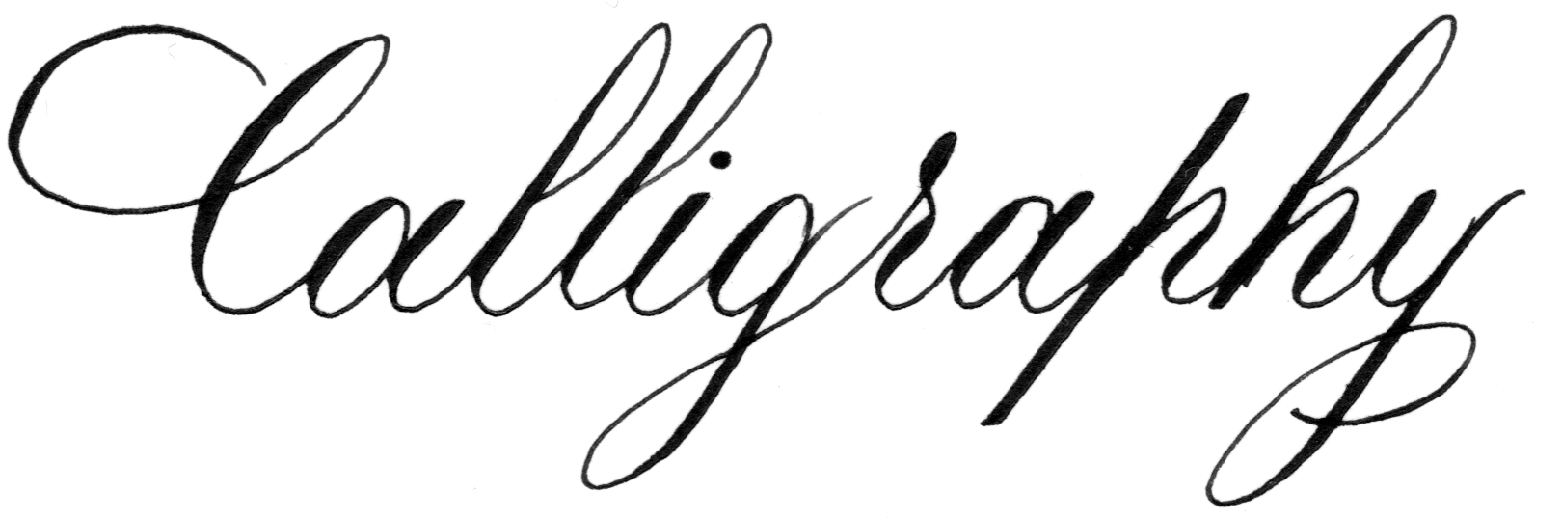

In [201]:
from skimage.io import imread, imshow

image_scan = imread(filename_scan, as_gray=True)
imshow(image_scan)

save_img(image_scan, 'calligraphy_scan')

## Convert image to binary

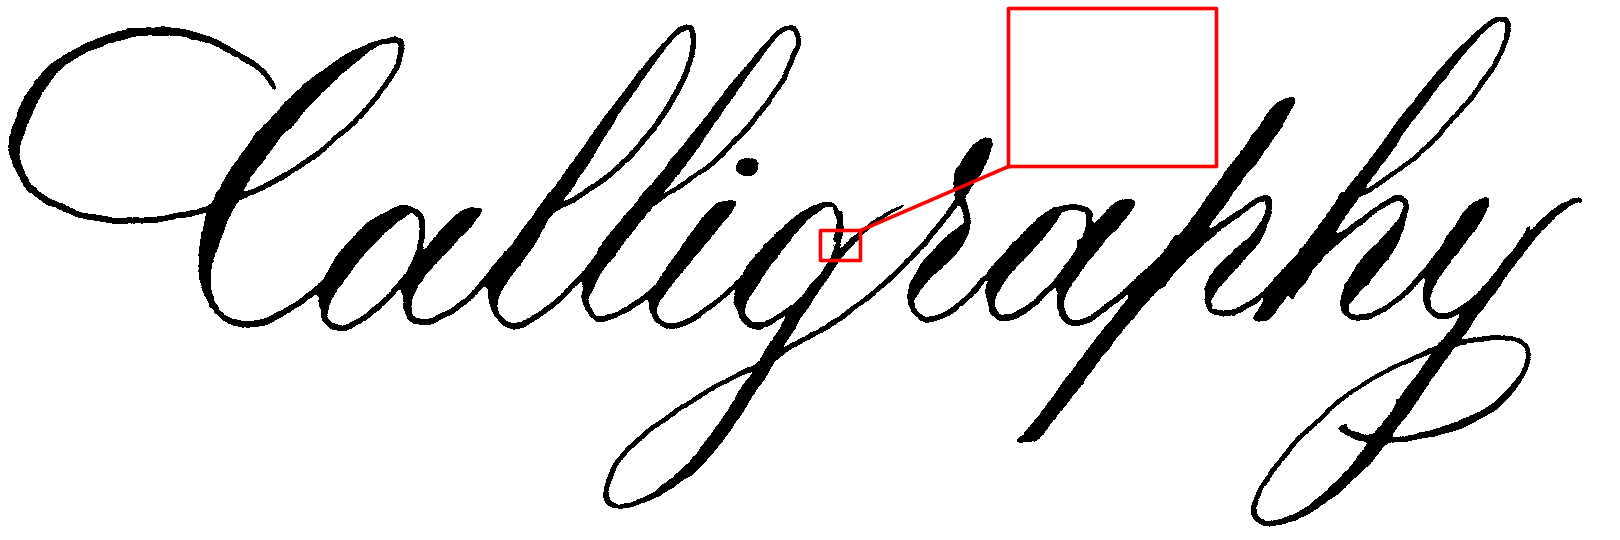

In [202]:
import numpy as np
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

dpi = 64.8
# Set display size of all plt plots
plt.rcParams['figure.figsize'] = (25, 25 / 3)
plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.subplot.bottom'] = 0
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.left'] = 0
plt.rcParams['figure.subplot.right'] = 1
plt.rcParams['figure.subplot.top'] = 1
plt.rcParams['figure.subplot.wspace'] = 0

# Hide/show axes
show_axes = False
rc = {"axes.spines.left": show_axes,
      "axes.spines.right": show_axes,
      "axes.spines.bottom": show_axes,
      "axes.spines.top": show_axes,
      "xtick.bottom": show_axes,
      "xtick.labelbottom": show_axes,
      "ytick.labelleft": show_axes,
      "ytick.left": show_axes}
plt.rcParams.update(rc)

# Use Otsu's thresholding method to determine the threshold
threshold = threshold_otsu(image_scan)

# Create binary image
image_binary = image_scan > threshold

# Show the grayscale and binary image
#plt.imshow(np.vstack((image_scan, image_binary)), cmap='gray', interpolation='nearest')
plt.imshow(image_binary, cmap='gray', interpolation='nearest')

#save_img(image_binary, 'calligraphy_binary')
plot_detail_on_image_and_save('calligraphy_binary', plt.gcf(), [840, 245], 20, 15, 5, change_corners=True)

## Remove islands

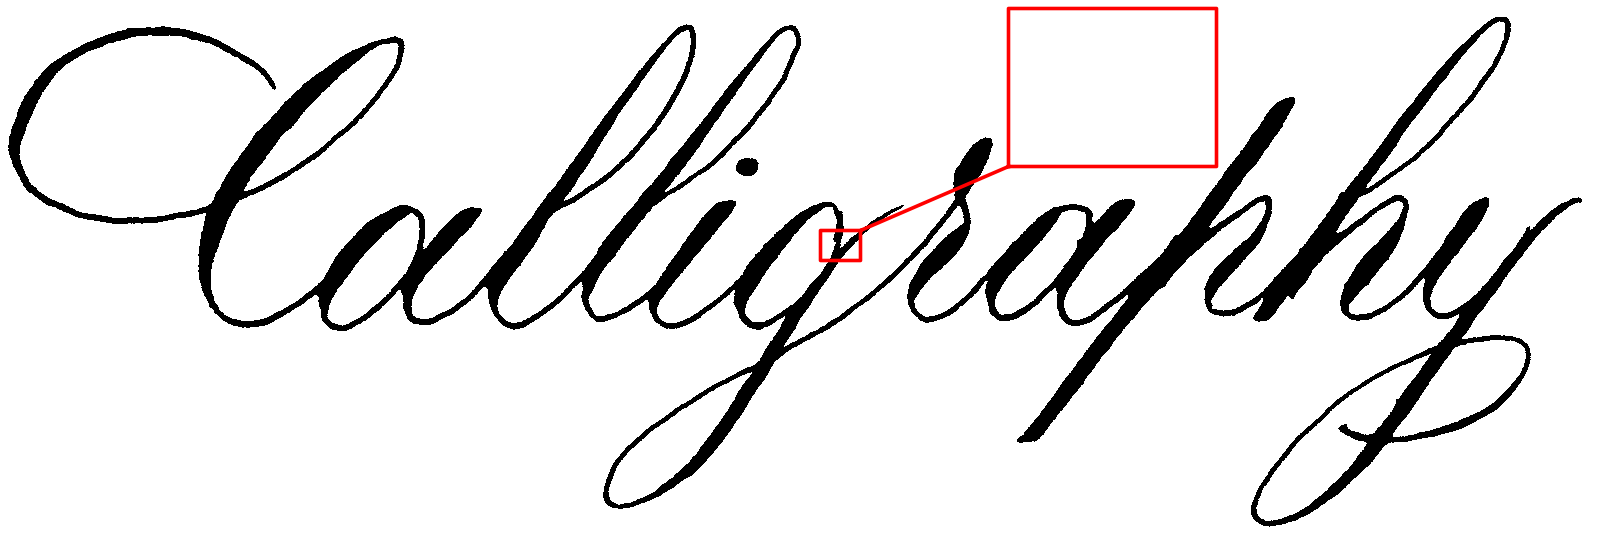

In [203]:
import skimage.morphology as mrp

# Use morphology methods to close small holes and open (remove) small pixel islands
image_cleaned = mrp.remove_small_holes(image_binary)
image_cleaned = mrp.remove_small_objects(image_cleaned)

plt.imshow(image_cleaned, cmap='gray', interpolation='nearest')

#save_img(image_cleaned, 'calligraphy_cleaned')
plot_detail_on_image_and_save('calligraphy_cleaned', plt.gcf(), [840, 245], 20, 15, 5, change_corners=True)

## Trace contours

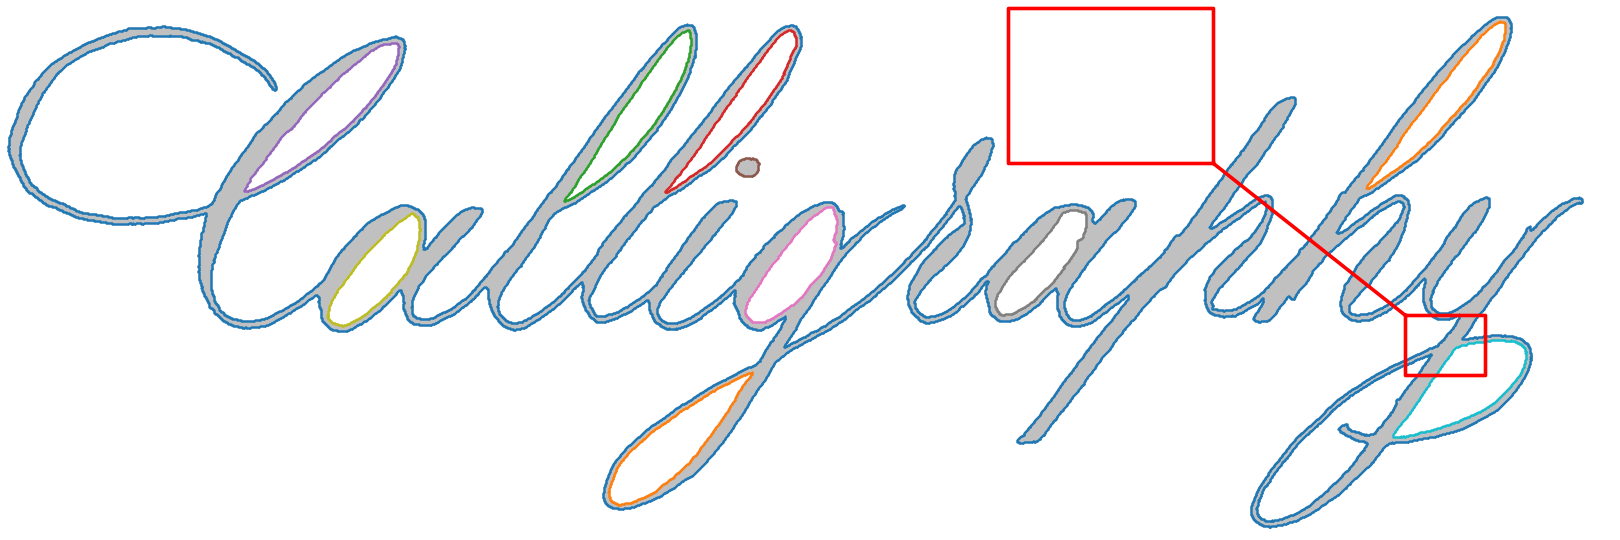

In [204]:
from skimage import measure
from skimage import filters

# Apply gaussian filter to slightly smoothen the edges
image_smoothened = filters.gaussian(image_cleaned, 0.5)

# Trace contours using skimage
contours = measure.find_contours(image_smoothened)

# Round contours to 1 decimal
for i, contour in enumerate(contours):
    contours[i] = np.round(contour, 1)

# Convert contours to one 2D array of all contour pixel pairs
contours_combined = np.asarray([pixel for contour in contours for pixel in contour])

# Display the image and plot all contours
fig, ax = plt.subplots()
#ax.imshow(np.zeros(np.shape(image_smoothened)), cmap='gray')
ax.imshow(image_smoothened, cmap='gray', alpha=0.25)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], marker='.', markersize=3, linestyle='none')

#save_plt_svg('calligraphy_contours')
plot_detail_on_image_and_save('calligraphy_contours', fig)

## Detect corners


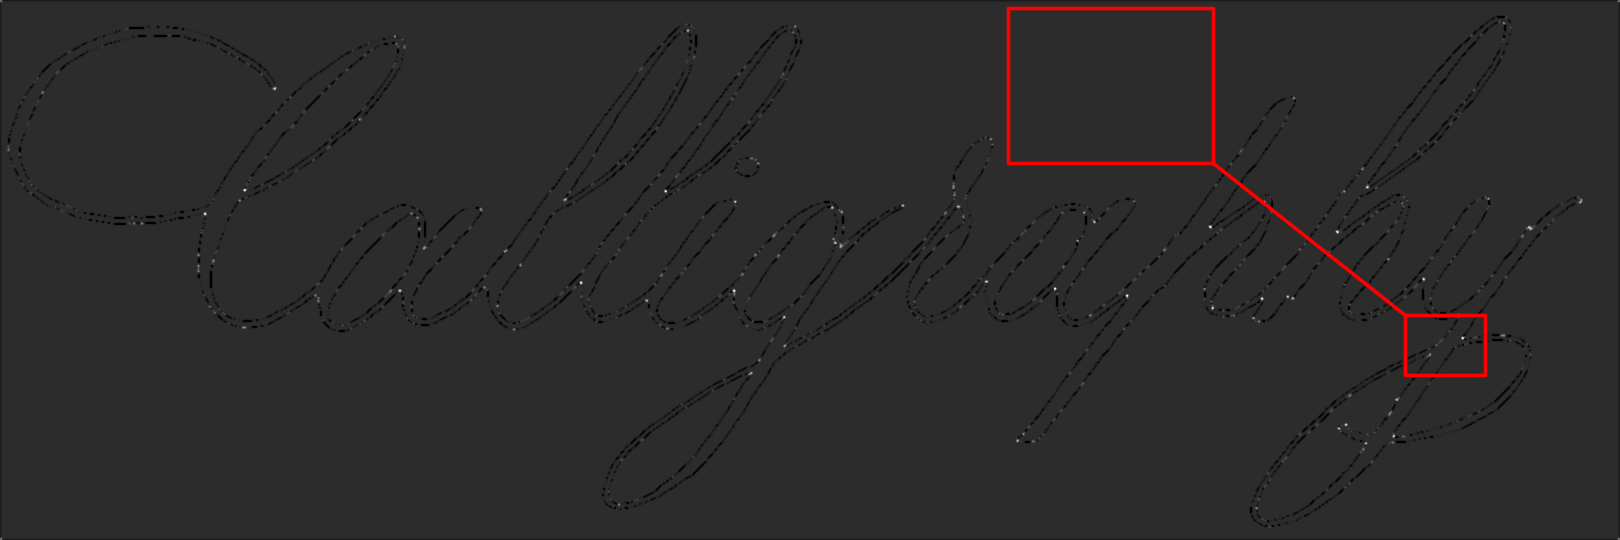

In [205]:
from skimage.feature import corner_harris

# Detect corners using the harris corner detector
corners_harris = corner_harris(image_cleaned)

# Show the harris corner values on the image
fig, ax = plt.subplots()
#ax.imshow(image_cleaned, cmap='gray', interpolation='nearest')
ax.imshow(corners_harris, cmap='gray', interpolation='nearest')

#save_img(corners_harris, 'calligraphy_harris_all')
plot_detail_on_image_and_save('calligraphy_harris_all', fig)

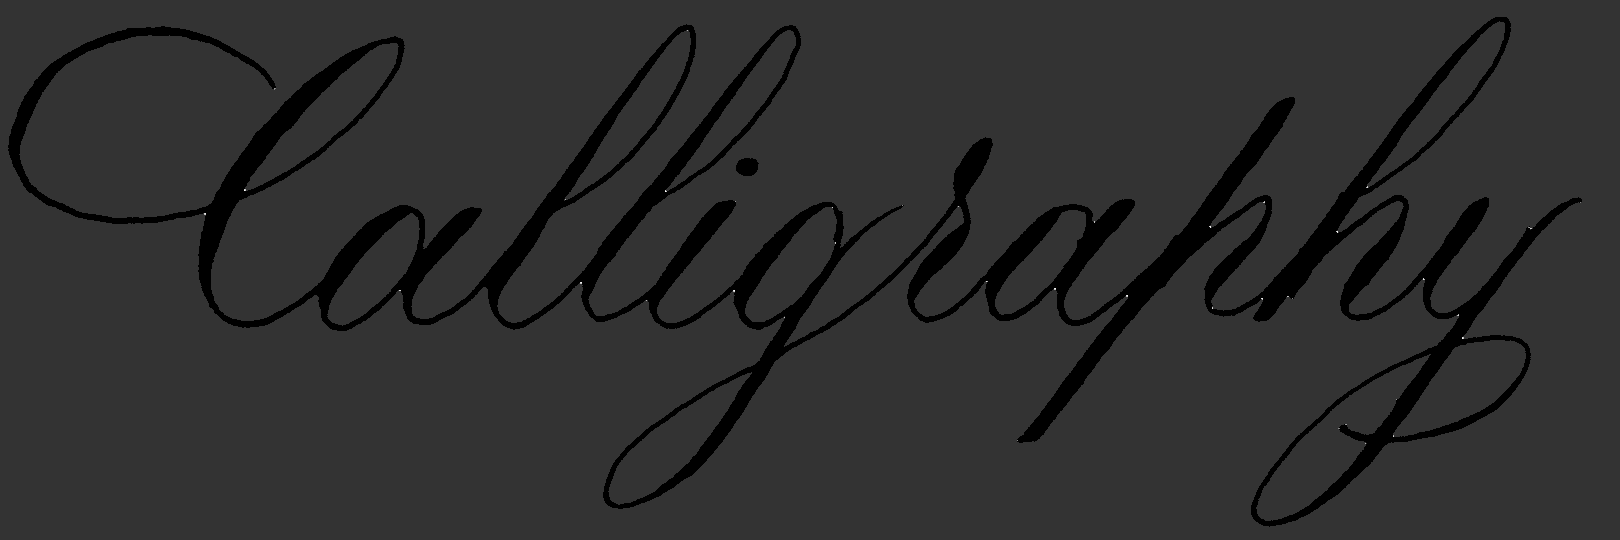

In [206]:
# Filter the brightest spots (highest harris corner value)
corner_threshold = 15
corners_harris[corners_harris < corner_threshold] = 0

# Show the remaining pixels on the image
fig, ax = plt.subplots()
ax.imshow(zoom_img(image_cleaned), cmap='gray', interpolation='nearest')
ax.imshow(zoom_img(corners_harris), cmap='gray', interpolation='nearest', alpha=0.8)

In [207]:
from skimage.feature import peak_local_max

# Get the brightest pixel of each harris corner pixel group
corners_points = peak_local_max(corners_harris)

fig, ax = plt.subplots(dpi=dpi * zoom_factor)
ax.imshow(zoom_img(image_cleaned), cmap='gray', interpolation='nearest')
ax.imshow(zoom_img(corners_harris), cmap='gray', alpha=0.8)
ax.plot(corners_points[:, 1] * zoom_factor, corners_points[:, 0] * zoom_factor, 'ro', markersize=10,
        markerfacecolor='none')

#save_plt_svg('calligraphy_harris_corners')
plot_detail_on_image_and_save('calligraphy_harris_corners', fig, multiplier=zoom_factor)

## Move corners onto contour

In [208]:
import numpy as np
import scipy.ndimage
from skimage.io import imread, imsave
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

red = [255, 0, 0]


def plot_detail_on_image(fig, detail_center, half_x, half_y, zoom):
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    canvas.draw()  # draw the canvas, cache the renderer
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    x = detail_center[1]
    y = detail_center[0]
    detail = image[y - half_y:y + half_y + 1, x - half_x:x + half_x + 1]
    magnified = scipy.ndimage.zoom(detail, zoom, order=0)
    ax.imshow(magnified)

[191 665] moved to [191.  664.6]
[290 734] moved to [289.6 734. ]
[ 295 1127] moved to [ 294.6 1127. ]
[ 338 1462] moved to [ 338.4 1462. ]
[190 244] moved to [190.4 244. ]
[282 581] moved to [281.6 581. ]
[ 288 1055] moved to [ 287.6 1055. ]
[ 231 1337] moved to [ 232.  1336.5]
[ 226 1210] moved to [ 227.  1209.5]
[ 298 1262] moved to [ 297.6 1262. ]
[213 205] moved to [212.6 205. ]
[ 279 1423] moved to [ 278.5 1424. ]
[ 187 1367] moved to [ 187.5 1367. ]
[ 308 1212] moved to [ 308.4 1212. ]
[281 986] moved to [280.5 986. ]
[ 436 1393] moved to [ 436.4 1393. ]
[290 400] moved to [289.6 400. ]
[ 424 1346] moved to [ 423.6 1346. ]
[ 315 1458] moved to [ 315.  1458.5]
[ 227 1529] moved to [ 227.  1529.5]
[ 202 1264] moved to [ 202.  1264.5]
[ 88 274] moved to [ 88.5 275. ]
[207 832] moved to [207.  832.4]
[201 735] moved to [201.  735.4]
[ 399 1396] moved to [ 398.6 1396. ]
[242 835] moved to [242.  835.4]
[317 784] moved to [317.  784.5]
[ 296 1287] moved to [ 295.6 1287. ]
[205 902] mo

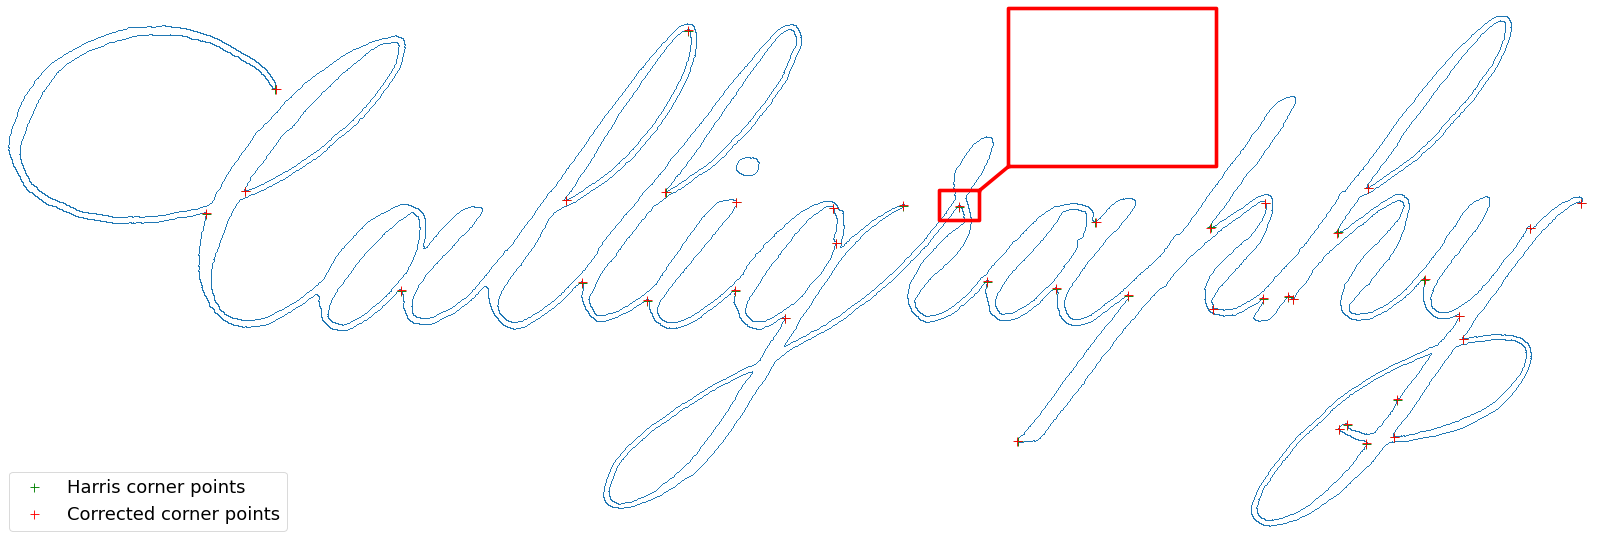

In [209]:
# From a corner peak local max go in x, y until contour reached
# (max. 5 px, otherwise outside corner -> fallback to the closest contour point)
contour_search_distance = 5

corners_corrected = []
for corner in corners_points:
    # Skip if already on contour
    if any(np.equal(contours_combined, corner).all(1)):
        print('skipped')
        continue

    x = corner[1]
    y = corner[0]
    x_direction = 0
    y_direction = 0

    for i in range(1, contour_search_distance * 10 + 1):
        # Search x
        if x_direction == 0:
            if any(np.equal(contours_combined, [y, x + i / 10]).all(1)):
                x_direction = 1
            elif any(np.equal(contours_combined, [y, x - i / 10]).all(1)):
                x_direction = -1

        # Search y
        if y_direction == 0:
            if any(np.equal(contours_combined, [y + i / 10, x]).all(1)):
                y_direction = 1
            elif any(np.equal(contours_combined, [y - i / 10, x]).all(1)):
                y_direction = -1

    # Move corner
    if x_direction != 0 and y_direction != 0:
        for i in range(1, contour_search_distance * 10 + 1):
            x_corr = x + (i / 10 * x_direction)
            y_corr = y + (i / 10 * y_direction)
            # Move diagonal
            closest_pixel = np.sum(np.abs(np.subtract(contours_combined, [y_corr, x_corr])), axis=1).argmin()
            # As contour pixels are maximum 1 px apart, accepted contour pixel needs to be max 0.5 away
            if np.less_equal(
                    np.abs(np.subtract(contours_combined[closest_pixel], [y_corr, x_corr])), [.5, .5]).all():
                corners_corrected.append(contours_combined[closest_pixel])
                print(f'{corner} moved to {contours_combined[closest_pixel]}')
                break
        else:
            print(f'{corner} could not be moved to contour.')

    # Fallback to initial solution for outside corners
    else:
        print('fallback', x_direction, y_direction)
        distances = np.sqrt((contours_combined[:, 0] - y) ** 2 + (contours_combined[:, 1] - x) ** 2)
        corners_corrected.append(contours_combined[np.argmin(distances)])

# Convert to numpy array
corners_corrected = np.asarray(corners_corrected)

# Show corners and corrected corners on the contour
fig, ax = plt.subplots()
ax.imshow(image_cleaned, alpha=0)  # invisible, only for shape of plot
ax.plot(contours_combined[:, 1], contours_combined[:, 0], linestyle='none', marker=',')
plt_harris_corners, = ax.plot(corners_points[:, 1], corners_points[:, 0], 'g+', markersize=10)
plt_corrected_corners, = ax.plot(corners_corrected[:, 1], corners_corrected[:, 0], 'r+', markersize=10)
ax.legend([plt_harris_corners, plt_corrected_corners], ['Harris corner points', 'Corrected corner points'],
          prop={'size': 20})

#save_plt_svg('calligraphy_corners_on_contour')
plot_detail_on_image_and_save('calligraphy_corners_on_contour', fig, [959, 205], 20, 15, 5, change_corners=True)

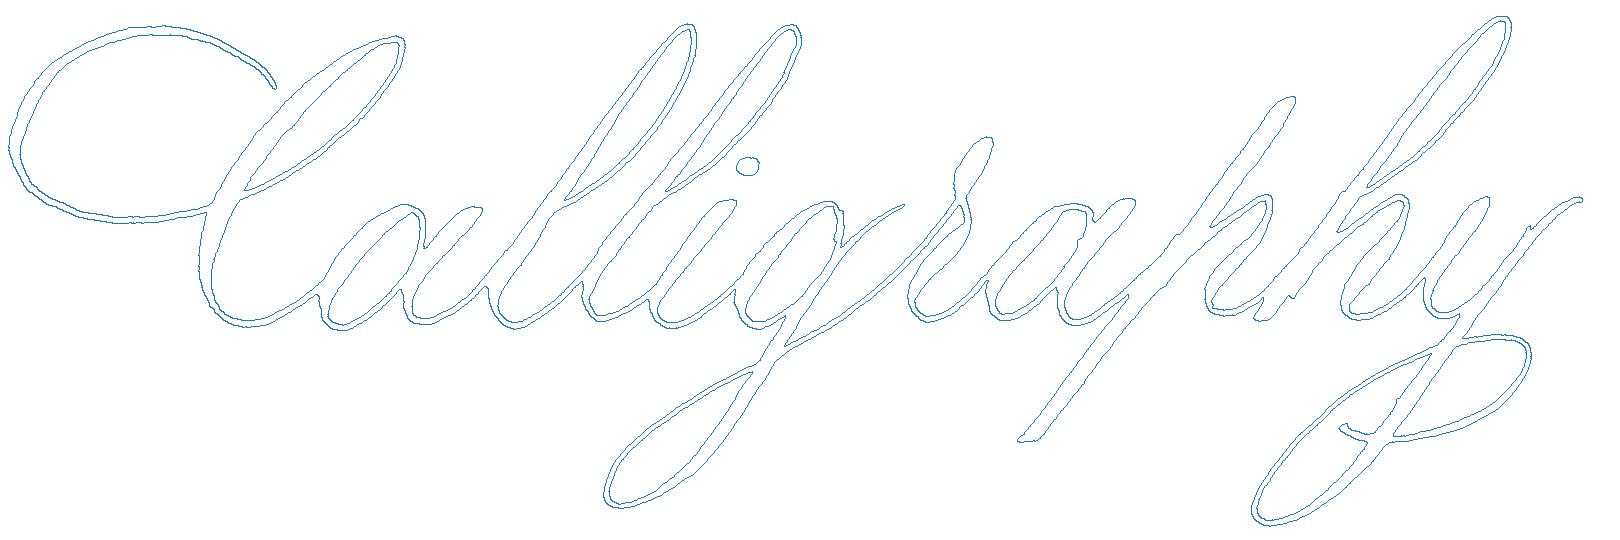

In [218]:
# Compare reference corners with manual ones
red = [255, 0, 10]
manual_painted = imread('comparison/calligraphy_manual_painted_corners.png')
manual_corners = np.where(np.all(manual_painted == red, axis=2))

fig, ax = plt.subplots()
ax.imshow(image_cleaned, alpha=0)  # invisible, only for shape of plot
ax.plot(contours_combined[:, 1], contours_combined[:, 0], linestyle='none', marker=',')

canvas = FigureCanvas(fig)
canvas.draw()  # draw the canvas, cache the renderer
width, height = np.int64(fig.get_size_inches() * fig.get_dpi())
image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)
fig, ax = plt.subplots(dpi=dpi*zoom_factor)
ax.imshow(zoom_img(image))

plt_manual_placed, = ax.plot(manual_corners[1]*zoom_factor, manual_corners[0]*zoom_factor, 'r+', markersize=10)
plt_corrected_corners, = ax.plot(corners_corrected[:, 1]*zoom_factor, corners_corrected[:, 0]*zoom_factor, 'g+', markersize=10)
ax.legend([plt_corrected_corners, plt_manual_placed], ['Corners from Reference Solution', 'Manual corner placement'], loc='lower left',
          prop={'size': 20})

#save_plt_svg('calligraphy_reference_corners_vs_manual')
plot_detail_on_image_and_save('calligraphy_reference_corners_vs_manual', fig, multiplier=zoom_factor)

## Split by corners

In [215]:
def split_contour_by_corners(contour, corners):
    segments = []
    first_segmentation_index = -1
    last_segmentation_index = 0
    has_corner = False

    # Search contour for matching corner
    for i, pixel in enumerate(contour):
        for j, corner in enumerate(corners):
            # If a corner is found, create a new segment
            if np.array_equal(corner, pixel):
                segments.append(contour[last_segmentation_index:(i + 1)])
                has_corner = True
                last_segmentation_index = i
                if first_segmentation_index == -1:
                    first_segmentation_index = i

    # Combine first and last segment to one segment and set start point to a corner point
    if first_segmentation_index > 0:
        combined_segment = list(contour[last_segmentation_index:len(contour) - 1]) + list(segments[0])
        segments.append(combined_segment)
        segments.pop(0)
    # Handle special case when start point already is a corner
    elif first_segmentation_index == 0:
        segments.pop(0)
    # If there is no corner found, take contour as segment
    else:
        segments.append(contour)

    return segments, has_corner


contours_in_segments = []
contour_has_corner = []
for contour in contours:
    segments, has_corner = split_contour_by_corners(contour, corners_corrected)
    contours_in_segments.append(segments)
    contour_has_corner.append(has_corner)

## Curve fitting

In [216]:
# Try to simplify the composite Bézier curve by replacing adjacent Bézier curves between two corner points with fewer curves than before
def join_adjacent_beziers(beziers, points, n_times, max_error, split_error, min_iterations_before_split):
    resulting_beziers = []
    l = len(beziers)
    # Try to replace Bézier curves, always try to take n_times + 1 Béziers at once
    if l >= n_times + 1:
        all_curves_covered = False
        for i in np.arange(0, l, n_times + 1):
            if i < l - n_times:
                if i == l + n_times:
                    all_curves_covered = True
                # Separate the first, last and intermediate Béziers
                bez1 = beziers[i]
                bez2 = beziers[i + 1:i + n_times]
                bez3 = beziers[i + n_times]
                # Find corresponding contour points
                start_index = np.nonzero(np.equal(points, bez1[0]).all(1))[0][0]
                end_index = np.nonzero(np.equal(points, bez3[3]).all(1))[0][-1]
                segment = points[start_index:] if all_curves_covered else points[start_index:end_index + 1]
                # Ensure that the start and end of the resulting composite Bézier curve stays the same
                left_tangent = normalize(bez1[1] - bez1[0])
                right_tangent = normalize(bez3[2] - bez3[3])
                # Fit a new set of Béziers
                new_beziers = fitCubic(segment, left_tangent, right_tangent, max_error, split_error,
                                       min_iterations_before_split)
                # If the resulting composite curve consists of fewer or equal curves, save them, otherwise discard and keep original ones
                if len(new_beziers) <= n_times + 1:
                    resulting_beziers.extend(new_beziers)
                else:
                    resulting_beziers.extend([bez1, *bez2, bez3])
            # If not all curves were covered before, add the remaining ones
            elif not all_curves_covered:
                resulting_beziers.extend([*beziers[-(l % (n_times + 1)):]])
    else:
        n_times = l
        resulting_beziers.extend(beziers)

    if n_times > 1 and (len(resulting_beziers) > 1):
        # Start recursive call
        return join_adjacent_beziers(resulting_beziers, points, n_times - 1, max_error, split_error,
                                     min_iterations_before_split)
    else:
        return resulting_beziers

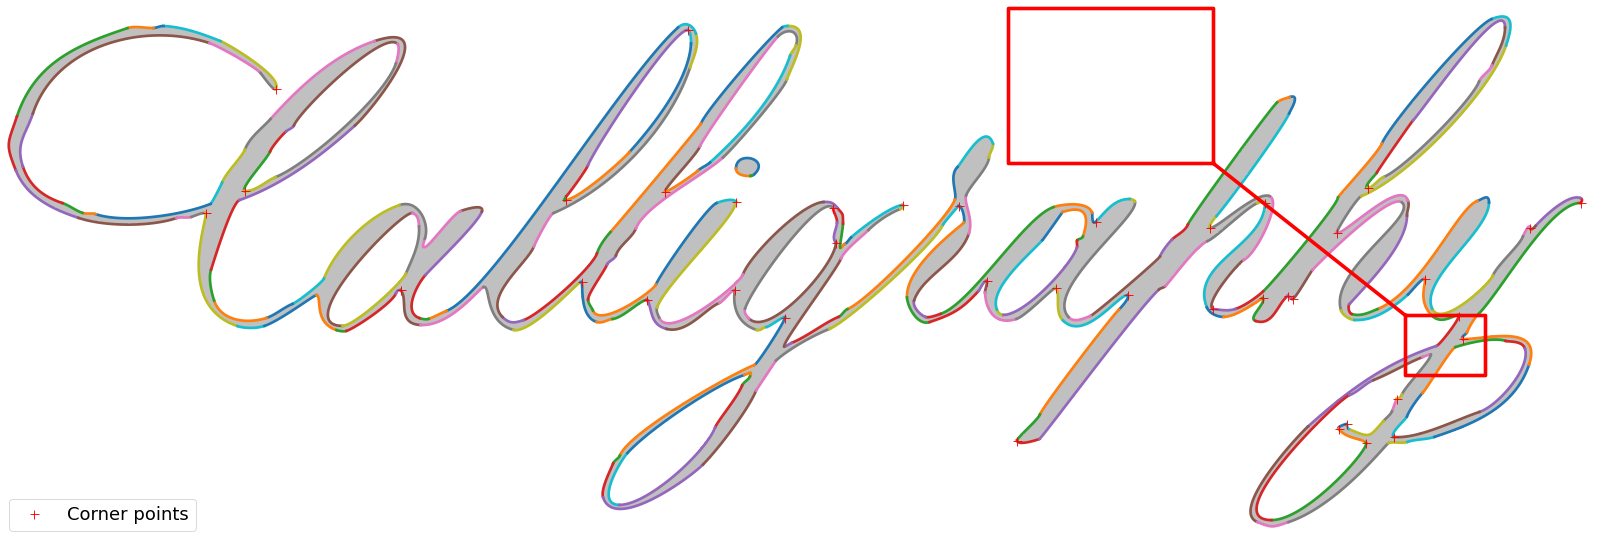

In [217]:
from libraries.fitCurves.fitCurves import *
from libraries import svg

# Parameters for Bézier fitting
max_error = 3
split_error = 30
min_iterations_before_split = 10

# Optimization parameters
max_error_2 = 2
min_iterations_before_split_2 = 15
max_error_join = 2
join_iterations = 7

# Prepare plot
fig, ax = plt.subplots()
# Use original image as background
ax.imshow(image_cleaned, cmap='gray', interpolation='nearest', alpha=0.25)

# Prepare SVG
svg_file = svg.create_file(filename_svg, np.shape(image_cleaned)[1], np.shape(image_cleaned)[0])
path_string = '\n'

for index, contour in enumerate(contours_in_segments):
    has_corner = contour_has_corner[index]
    svg_path = ''

    # Fit a composite cubic Bézier curve to each segment
    for i, segment in enumerate(contour):
        beziers = fitCurve(segment, has_corner, max_error, split_error, min_iterations_before_split)

        # Further optimize by joining adjascent Bézier curves together
        if len(beziers) > 1:
            beziers = join_adjacent_beziers(beziers, segment, join_iterations, max_error_2, max_error_join,
                                            min_iterations_before_split_2)

        # Add each cubic Bézier to the SVG path
        for j, bez in enumerate(beziers):
            bez = np.stack(bez)
            bez = np.round(bez, 2)

            # Build SVG path according to the specification
            if i == 0 and j == 0:
                svg_path = 'M{x0},{y0} C{x1},{y1}, {x2},{y2}, {x3},{y3}'.format(
                    x0=bez[0, 1],
                    y0=bez[0, 0],
                    x1=bez[1, 1],
                    y1=bez[1, 0],
                    x2=bez[2, 1],
                    y2=bez[2, 0],
                    x3=bez[3, 1],
                    y3=bez[3, 0]
                )
            else:
                svg_path += ', {x1},{y1}, {x2},{y2}, {x3},{y3}'.format(
                    x1=bez[1, 1],
                    y1=bez[1, 0],
                    x2=bez[2, 1],
                    y2=bez[2, 0],
                    x3=bez[3, 1],
                    y3=bez[3, 0]
                )

            # Plot the composite Bézier curve
            curve = []
            for t in np.linspace(0, 1, 50):
                curve.append(bezier.q(bez, t))
            curve = np.stack(curve)
            ax.plot(curve[:, 1], curve[:, 0], linewidth=3)

    # Append the curve to the overall SVG path string
    path_string += f'{svg_path}Z\n'

# Add path to SVG file and save
svg.add_path_element(svg_file, path_string)
svg.save_file(svg_file)

# Show the corner points
plt_corners, = ax.plot(corners_corrected[:, 1], corners_corrected[:, 0], 'r+', markersize=10)
ax.legend([plt_corners], ['Corner points'], loc='lower left', prop={'size': 20})

if save_final_plot:
    #save_plt_svg(filename_result_figure)
    plot_detail_on_image_and_save(filename_result_figure, fig)